<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> AC295: Advanced Practical Data Science </h1>

## Practicum 2: Visual Question Answering

**Harvard University, Fall 2020**  
**Instructors**: Pavlos Protopapas  

### **Team: $\alpha\beta normal$ $Distri\beta ution$**
#### **Roht Beri, Eduardo Peynetti, Jessica Wijaya, Stuart Neilson**

## Creating TFRecords Datasets

### Install Packages

In [1]:
!pip3 install transformers

     |████████████████████████████████| 1.3MB 5.3MB/s 
     |████████████████████████████████| 1.1MB 31.9MB/s 
     |████████████████████████████████| 890kB 39.8MB/s 
     |████████████████████████████████| 2.9MB 43.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=3a194ed8434063955d09ac8d8186cd463238ec8462b41da1e07dd4d97bbdd9ac
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### Imports

In [2]:
import os
import requests
import tempfile
import zipfile
import shutil
import json
import time
import sys
import cv2
import numpy as np
import pandas as pd
from collections import Counter
from glob import glob
from google.colab import drive
from google.colab import auth
from tqdm.notebook import trange, tqdm
import subprocess
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from transformers import BertTokenizer

### Utils

In [3]:
# Paths to big and small datasets
PATHS_BIG = [
    'https://public-dataset-store.s3.amazonaws.com/visualqa_2017/train2014.zip',
    'https://public-dataset-store.s3.amazonaws.com/visualqa_2017/v2_Questions_Train_mscoco.zip',
    'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip',
    'https://public-dataset-store.s3.amazonaws.com/visualqa_2017/val2014.zip',
    'https://public-dataset-store.s3.amazonaws.com/visualqa_2017/v2_Questions_Val_mscoco.zip',
    'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip'
]

PATHS_SMALL = [
    'https://storage.googleapis.com/ac295-data-store/visualqa_2017_small/train2014.zip',
    'https://public-dataset-store.s3.amazonaws.com/visualqa_2017/v2_Questions_Train_mscoco.zip',
    'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip',
    'https://storage.googleapis.com/ac295-data-store/visualqa_2017_small/val2014.zip',
    'https://public-dataset-store.s3.amazonaws.com/visualqa_2017/v2_Questions_Val_mscoco.zip',
    'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip'
]

In [4]:
# Download Data 
# Credit: https://github.com/arya46/portfolio_notebooks/blob/master/Visual%20Question%20Answering/VQA%203%20Model.ipynb
def download_vqa_data(paths):
    Questions_Train_mscoco = tf.keras.utils.get_file(
        'v2_Questions_Train_mscoco.zip',
        cache_subdir=os.path.abspath('/content/data'),
        origin = paths[1],
        extract = True
    )
    print("Training Question Extracted")

    Questions_Val_mscoco = tf.keras.utils.get_file('v2_Questions_Val_mscoco.zip',
        cache_subdir=os.path.abspath('/content/data'),
        origin = paths[4],
        extract = True
    )
    print("Validation Question Extracted")

    Annotations_Train_mscoco = tf.keras.utils.get_file(
        'v2_Annotations_Train_mscoco.zip',
        cache_subdir=os.path.abspath('/content/data'),
        origin = paths[2],
        extract = True
    )
    print("Training Annotations Extracted")

    Annotations_Val_mscoco = tf.keras.utils.get_file(
        'v2_Annotations_Val_mscoco.zip',
        cache_subdir=os.path.abspath('/content/data'),
        origin = paths[5],
        extract = True
    )
    print("Validation Annotations Extracted")

    image_train = tf.keras.utils.get_file(
        'train2014.zip',
        cache_subdir=os.path.abspath('/content/data'),
        origin = paths[0],
        extract = True
    )
    print("Training Images Extracted")

    image_val = tf.keras.utils.get_file(
        'val2014.zip',
        cache_subdir=os.path.abspath('/content/data'),
        origin = paths[3],
        extract = True
    )
    print("Validation Images Extracted")

    # Remove the zip files
    os.remove(Questions_Train_mscoco)
    os.remove(Questions_Val_mscoco)
    os.remove(Annotations_Train_mscoco)
    os.remove(Annotations_Val_mscoco)
    os.remove(image_train)
    os.remove(image_val)

In [5]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.
# Credit: https://www.tensorflow.org/tutorials/load_data/tfrecord

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [6]:
# Get Top K answers
def get_top_K_answers(k):
    anno_train = json.load(open(f'/content/data/v2_mscoco_train2014_annotations.json', 'r'))
    anno_val = json.load(open(f'/content/data/v2_mscoco_val2014_annotations.json', 'r'))
    answers = []

    for i in range(len(anno_train['annotations'])):
        answers.append(anno_train['annotations'][i]['multiple_choice_answer'])

    for i in range(len(anno_val['annotations'])):
        answers.append(anno_val['annotations'][i]['multiple_choice_answer'])

    answers = Counter(answers)
    answers = pd.Series(answers, name="frequency")
    answers = answers.to_frame().sort_values("frequency", axis=0, ascending=False)
    answers.iloc[:k].to_csv("/content/data/answers.csv")
    answers = answers.index[:k]

    return list(answers)

In [7]:
IMG_CHANNELS = 3
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_SHARDS = 10
K = 10

# Function to create TFRecords for the dataset
# Credit: http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/
# Credit: https://github.com/shiyangdaisy23/QTA-in-VQA/blob/master/Datapreprocess/textpreprocess.py
def create_TFRecords(subset, top_answers):
    """
    Creates a TFRecords file whose elements are (image_path, question, answer)

    Input:
      subset: subset can be train2014 or val2014
    """
    anno = json.load(open(f'/content/data/v2_mscoco_{subset}_annotations.json', 'r'))
    ques = json.load(open(f'/content/data/v2_OpenEnded_mscoco_{subset}_questions.json', 'r'))
    imdir='/content/data/%s/COCO_%s_%012d.jpg' ## COCO_train2014_000000291417.jpg

    num_annotations = len(anno['annotations'])
    shard_size = num_annotations//NUM_SHARDS
    num_shards = NUM_SHARDS + (num_annotations%NUM_SHARDS > 0)

    if not os.path.exists(f'/content/data/{subset}_tf'):
        os.mkdir(f'/content/data/{subset}_tf')
    
    path = "/content/data/{}_tf/vaq_raw_{}_{}-of-{}.records"

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

    for j in trange(num_shards):
    # TFRecord writer initialized
        shard_path = path.format(subset, subset, '%.2d'%(j), '%.2d'%(num_shards-1))
        writer = tf.io.TFRecordWriter(shard_path)

        for i in trange(j*shard_size, min((j+1)*shard_size, num_annotations)):

            answer = anno['annotations'][i]['multiple_choice_answer']

            if answer in top_answers:
                answer = top_answers.index(answer)
                #answer = to_categorical(answer, num_classes=K, dtype='float32')
                #answer = answer.tostring()

                question = ques['questions'][i]['question']
                question_token = tokenizer.encode_plus(
                    question, 
                    add_special_tokens = True, # add [CLS], [SEP]
                    max_length = 24, # max length of the text that can go to BERT (<=512)
                    padding='max_length',
                    return_attention_mask = True, # add attention mask to not focus on pad tokens
                    truncation='longest_first',
                    return_tensors="tf"
                )
                question_input = question_token['input_ids'].numpy().tostring()
                question_type = question_token['token_type_ids'].numpy().tostring()
                question_attention = question_token['attention_mask'].numpy().tostring()
                
                # Read and resize the image
                image_path = imdir%(subset, subset, anno['annotations'][i]['image_id'])
                img = cv2.imread(image_path)
                img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
                img = np.asarray(img)
                img = tf.constant(img)
                img_raw = tf.io.encode_jpeg(img)

                # Create tf.train.Example
                feature={
                    'image_raw': _bytes_feature(img_raw), 
                    'question' : _bytes_feature(question.encode('utf-8')),
                    'input_ids': _bytes_feature(question_input),
                    'token_type_ids': _bytes_feature(question_type),
                    'attention_mask': _bytes_feature(question_attention), 
                    'answer': _int64_feature(answer)
                }
                features=tf.train.Features(feature=feature)
                example = tf.train.Example(features=features)

                # Wrtie the TFRecord
                writer.write(example.SerializeToString())

        # Close the TFRecord file
        writer.close()

    # Cleanup
    os.remove(f'/content/data/v2_mscoco_{subset}_annotations.json')
    os.remove(f'/content/data/v2_OpenEnded_mscoco_{subset}_questions.json')
    shutil.rmtree(f'/content/data/{subset}')

### Download Data

In [8]:
# Set the paths
#paths = PATHS_SMALL
paths = PATHS_BIG

# Download data
download_vqa_data(paths)

7241728/7239401 [==============================] - 2s 0us/step
Training Question Extracted
3497984/3494929 [==============================] - 1s 0us/step
Validation Question Extracted
21716992/21708861 [==============================] - 3s 0us/step
Training Annotations Extracted
10526720/10518930 [==============================] - 2s 0us/step
Validation Annotations Extracted
13510574080/13510573713 [==============================] - 791s 0us/step
Training Images Extracted
6645014528/6645013297 [==============================] - 403s 0us/step
Validation Images Extracted


### Get Top Answers

In [9]:
top_answers = get_top_K_answers(K)

### Create TFRecords Dataset

In [10]:
create_TFRecords('train2014', top_answers)
create_TFRecords('val2014', top_answers)

### Transfer TFRecords to Google Drive

In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [13]:
#shutil.rmtree('/content/drive/My Drive/Practicum2Data/big/val2014_tf')
#shutil.rmtree('/content/drive/My Drive/Practicum2Data/big/train2014_tf')
#shutil.rmtree('/content/drive/My Drive/Practicum2Data/val2014_tf')
#shutil.rmtree('/content/drive/My Drive/Practicum2Data/train2014_tf')
if not os.path.exists('/content/drive/My Drive/Practicum2Data/big2'):
    os.mkdir('/content/drive/My Drive/Practicum2Data/big2')
!cp -r /content/data/* "/content/drive/My Drive/Practicum2Data/big2"

In [24]:
!mv "/content/drive/My Drive/Practicum2Data/big2/data" "/content/drive/My Drive/Practicum2Data"

### Transfer TFRecords to GCP Bucket

In [ ]:
auth.authenticate_user()

project_id = 'ac295-data-science-289004'
bucket_name = 'practicum2-abnormal-distribution'

!gcloud config set project {project_id}
!gsutil ls

!gsutil -m cp -r "/content/drive/My Drive/Practicum2Data/big/*" gs://{bucket_name}/

### Read TFRecords Dataset

In [14]:
filenames = ['/content/data/val2014_tf/vaq_raw_val2014_00-of-10.records']
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [15]:
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "answer"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "attention_mask"
    value {
      bytes_list {
        value: "\001\000\000\000\001\000\000\000\001\000\000\000\001\000\000\000\001\000\000\000\001\000\000\000\001\000\000\000\001\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000"
      }
    }
  }
  feature {
    key: "image_raw"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\001,\001,\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\0

In [18]:
# Create a dictionary describing the features.
image_features={
    'image_raw': tf.io.FixedLenFeature([], tf.string), 
    'question' : tf.io.FixedLenFeature([], tf.string),
    'input_ids': tf.io.FixedLenFeature([], tf.string),
    'token_type_ids': tf.io.FixedLenFeature([], tf.string),
    'attention_mask': tf.io.FixedLenFeature([], tf.string), 
    'answer': tf.io.FixedLenFeature([], tf.int64)
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_features)

parsed_image_dataset = raw_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {answer: (), attention_mask: (), image_raw: (), input_ids: (), question: (), token_type_ids: ()}, types: {answer: tf.int64, attention_mask: tf.string, image_raw: tf.string, input_ids: tf.string, question: tf.string, token_type_ids: tf.string}>

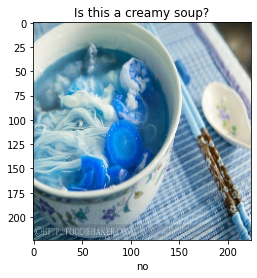

tf.Tensor(1, shape=(), dtype=int64)


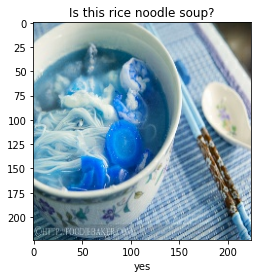

tf.Tensor(0, shape=(), dtype=int64)


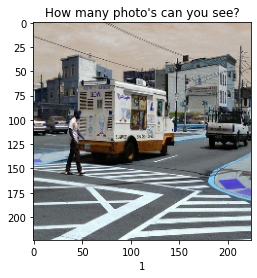

tf.Tensor(2, shape=(), dtype=int64)


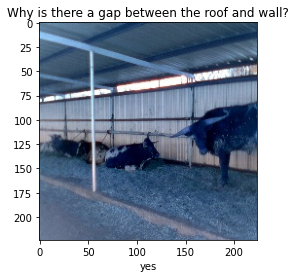

tf.Tensor(0, shape=(), dtype=int64)


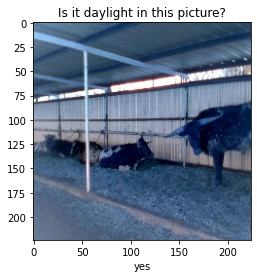

tf.Tensor(0, shape=(), dtype=int64)


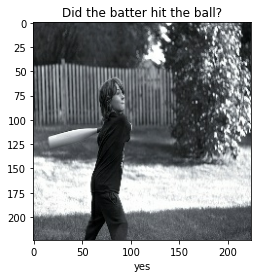

tf.Tensor(0, shape=(), dtype=int64)


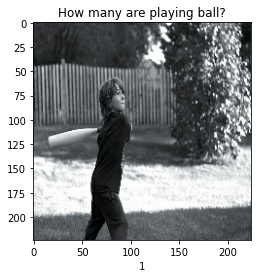

tf.Tensor(2, shape=(), dtype=int64)


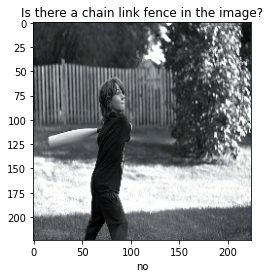

tf.Tensor(1, shape=(), dtype=int64)


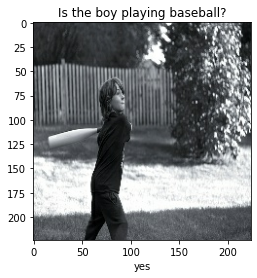

tf.Tensor(0, shape=(), dtype=int64)


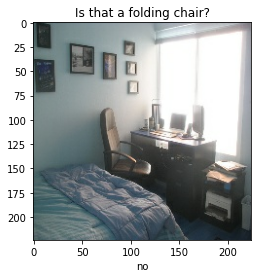

tf.Tensor(1, shape=(), dtype=int64)


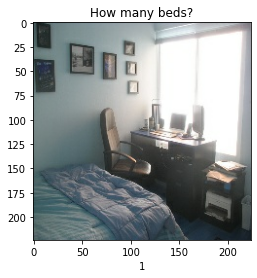

tf.Tensor(2, shape=(), dtype=int64)


In [19]:
i = 0
for image_features in parsed_image_dataset:
    i += 1
    img = tf.io.decode_jpeg(image_features['image_raw'], 3)
    plt.imshow(img)
    plt.title(image_features['question'].numpy().decode('utf-8'))
    plt.xlabel(top_answers[image_features['answer']])
    plt.show()
    print(image_features['answer'])
    if i > 10:
        break

In [ ]:
type(image_features['question']) #.numpy().decode('utf-8'))

tensorflow.python.framework.ops.EagerTensor